In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)


In [2]:
df = pd.read_csv("titanic_augmented.csv")

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


In [3]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [4]:
#feature selection
TARGET = "Survived"

drop_cols = [
    "PassengerId",
    "Name",
    "Ticket",
    "Cabin",
    "booking_reference",
    "service_id"
]

X = df.drop(columns=[TARGET] + drop_cols)
y = df[TARGET]

X.shape, y.shape


((891, 19), (891,))

In [5]:
#data splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train survival rate:", y_train.mean())
print("Test survival rate:", y_test.mean())


Train size: (668, 19)
Test size: (223, 19)
Train survival rate: 0.38323353293413176
Test survival rate: 0.38565022421524664


In [6]:
#feature typing
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)


Numeric features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'is_alone', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']
Categorical features: ['Sex', 'Embarked', 'title', 'title_group', 'cabin_deck']


In [7]:
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

preprocessor

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape :", X_test_processed.shape)


Processed train shape: (668, 46)
Processed test shape : (223, 46)


# Random Forest

In [15]:
# =========================
# Random Forest (Full)
# =========================

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# --- 2) Model pipeline ---
rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

# --- 3) CV + tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 4, 6, 8, 10],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", None]
}

grid = GridSearchCV(
    rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# --- 4) Final test evaluation ---
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

# --- 5) Interpretation (feature importances) ---

# Get feature names after preprocessing
feature_names_full = best_rf.named_steps["preprocess"].get_feature_names_out()

# RandomForest feature importances
importances = best_rf.named_steps["model"].feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names_full,
    "importance": importances
}).sort_values("importance", ascending=False)

display(imp_df)

Best params: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 600}
Best CV ROC AUC: 0.8848870927923148
Test ROC AUC: 0.8576642335766422
Test Accuracy: 0.7937219730941704
Confusion matrix:
 [[116  21]
 [ 25  61]]


,feature,importance
34,cat__title_group_Mr,0.076886
14,cat__Sex_female,0.075556
9,num__fare_per_person,0.074032
15,cat__Sex_male,0.072059
4,num__Fare,0.068301
28,cat__title_Mr,0.062925
5,num__name_length,0.054236
10,num__age_fare_ratio,0.054084
1,num__Age,0.052321
12,num__cabin_score,0.051943


# reduced features

In [9]:
drop_more = [
    "name_word_count",
    "ticket_group_size",
    "cabin_room_number",
    "family_size"
]

X_reduced = df.drop(columns=[TARGET] + drop_cols + drop_more)
y = df[TARGET]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

num_features_r = Xr_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_r = Xr_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_r = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_r, num_features_r),
        ("cat", categorical_transformer_r, cat_features_r)
    ],
    remainder="drop"
)

rf_simple = Pipeline([
    ("preprocess", preprocessor_r),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 4, 6, 8, 10],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", None]
}

grid_simple = GridSearchCV(
    rf_simple,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_simple.fit(Xr_train, yr_train)

print("Best params (simple):", grid_simple.best_params_)
print("Best CV AUC (simple):", grid_simple.best_score_)

best_rf_simple = grid_simple.best_estimator_

yr_pred_rf = best_rf_simple.predict(Xr_test)
yr_prob_rf = best_rf_simple.predict_proba(Xr_test)[:, 1]

print("Simple model accuracy:", accuracy_score(yr_test, yr_pred_rf))
print("Simple model ROC AUC :", roc_auc_score(yr_test, yr_prob_rf))

Best params (simple): {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 400}
Best CV AUC (simple): 0.8772782000975982
Simple model accuracy: 0.8116591928251121
Simple model ROC AUC : 0.8584281106773044


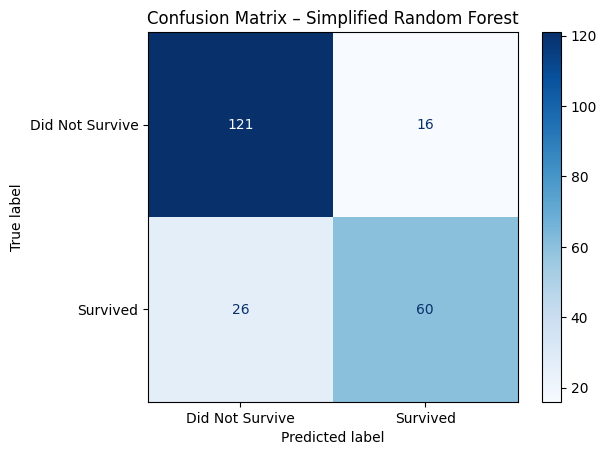

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(yr_test, yr_pred_rf)  # simplified RF, threshold 0.5

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Did Not Survive", "Survived"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Simplified Random Forest")
plt.show()

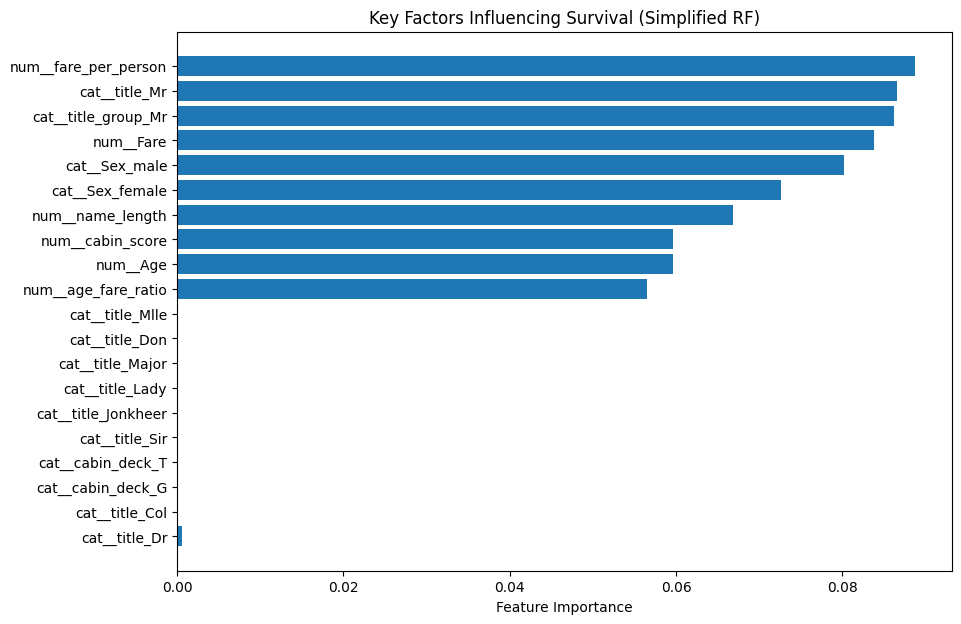

In [11]:
# Get feature names (reduced version)
feature_names_r = best_rf_simple.named_steps["preprocess"].get_feature_names_out()

importances_r = best_rf_simple.named_steps["model"].feature_importances_

imp_df_r = pd.DataFrame({
    "feature": feature_names_r,
    "importance": importances_r
}).sort_values("importance", ascending=False)

top_pos = imp_df_r.head(10)                 # most important
top_neg = imp_df_r.tail(10).sort_values("importance")  # least important (optional)

plot_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(10, 7))
plt.barh(plot_df["feature"], plot_df["importance"])
plt.xlabel("Feature Importance")
plt.title("Key Factors Influencing Survival (Simplified RF)")
plt.gca().invert_yaxis()
plt.show()

# adjust the decision threshold

In [12]:
import numpy as np

threshold = 0.45
y_pred_rf_045 = (yr_prob_rf >= threshold).astype(int)

print("Accuracy :", accuracy_score(yr_test, y_pred_rf_045))
print("Recall   :", recall_score(yr_test, y_pred_rf_045))
print("Precision:", precision_score(yr_test, y_pred_rf_045))

Accuracy : 0.8116591928251121
Recall   : 0.7441860465116279
Precision: 0.7619047619047619


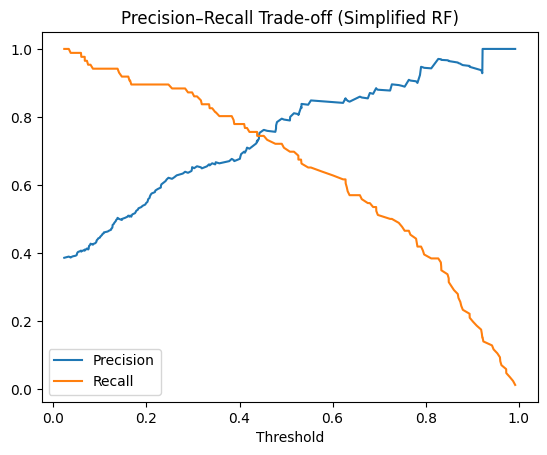

In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(yr_test, yr_prob_rf)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off (Simplified RF)")
plt.show()

# Compare logictic version

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# --- Model 1: Full RF (threshold = 0.50) ---
full_pred = y_pred_rf
full_prob = y_prob_rf

# --- Model 2: Simplified RF reduced features (threshold = 0.50) ---
simple_pred_05 = yr_pred_rf
simple_prob = yr_prob_rf

# --- Model 3: Simplified RF (threshold = 0.45) ---
simple_pred_045 = y_pred_rf_045

rf_results = pd.DataFrame([
    {
        "Model": "Full RF (thr=0.50)",
        "Accuracy": accuracy_score(y_test, full_pred),
        "Precision": precision_score(y_test, full_pred),
        "Recall": recall_score(y_test, full_pred),
        "F1": f1_score(y_test, full_pred),
        "ROC AUC": roc_auc_score(y_test, full_prob)
    },
    {
        "Model": "Simplified RF reduced features (thr=0.50)",
        "Accuracy": accuracy_score(yr_test, simple_pred_05),
        "Precision": precision_score(yr_test, simple_pred_05),
        "Recall": recall_score(yr_test, simple_pred_05),
        "F1": f1_score(yr_test, simple_pred_05),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    },
    {
        "Model": "Simplified RF (thr=0.45)",
        "Accuracy": accuracy_score(yr_test, simple_pred_045),
        "Precision": precision_score(yr_test, simple_pred_045),
        "Recall": recall_score(yr_test, simple_pred_045),
        "F1": f1_score(yr_test, simple_pred_045),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    }
])

rf_results.round(3)


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Full RF (thr=0.50),0.794,0.744,0.709,0.726,0.858
1,Simplified RF reduced features (thr=0.50),0.812,0.789,0.698,0.741,0.858
2,Simplified RF (thr=0.45),0.812,0.762,0.744,0.753,0.858
